This notebook demonstrates an end to end example of compiling a circuit to its pauli-check variant, mapping to an IBM QPU, and executing it on a noisy simulator. 

In [2]:
import numpy as np

from quantem.utils import (
    convert_to_PCS_circ_largest_clifford,
    get_VF2_layouts,
)
from quantem.pauli_checks import postselect_counts

## Generate circuit

In [3]:
from qiskit.circuit import QuantumCircuit


def hydrogen_trial_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    # prepare the Hartree-Fock state
    qc.x(0)
    qc.x(1)

    qc.rx(np.pi / 2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)

    # qc.barrier()
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    # qc.barrier()

    qc.rz(1.0, 3)

    qc.cx(2, 3)
    qc.cx(1, 2)
    qc.cx(0, 1)

    qc.rx(-np.pi / 2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)

    return qc

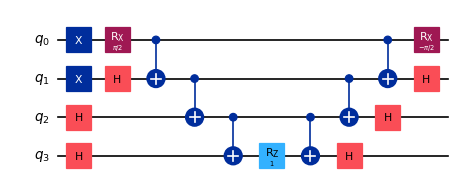

In [4]:
circ = hydrogen_trial_circuit(4)
circ.draw("mpl", scale=0.6)

## Apply checks to larget Clifford blcok

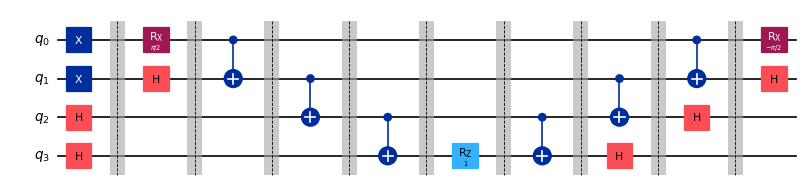

In [5]:
from qiskit_addon_utils.slicing import combine_slices, slice_by_depth

slices = slice_by_depth(circ, 1)
combined_slices = combine_slices(slices, include_barriers=True)
combined_slices.draw("mpl", scale=0.6)

In [6]:
num_qubits = 4
num_checks = 2

# To do: Change function name
sign_list, pcs_circ = convert_to_PCS_circ_largest_clifford(circ, num_qubits, num_checks)

Largest Clifford block is from slice 6 to 8.
Found check 1: +1XXXX, +1IIIX
Found check 2: +1IIIZ, +1IIIZ
Required number of checks found.
p1_list =  [['+1XXXX', '+1IIIX'], ['+1IIIZ', '+1IIIZ']]


['+1', '+1']


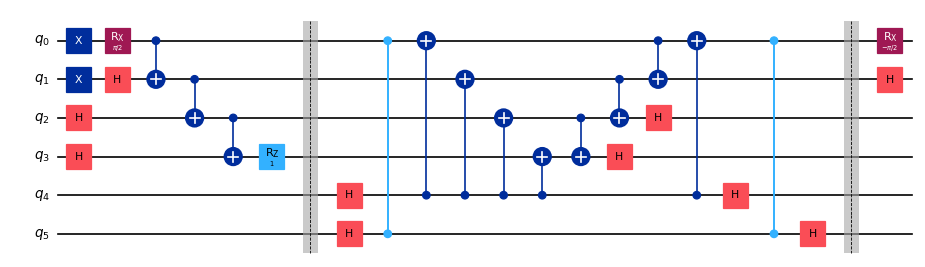

In [7]:
print(sign_list)
pcs_circ.draw("mpl", scale=0.6, fold=-1)

## Select backend

In [8]:
from qiskit_ibm_runtime.fake_provider import *

fake_backend = FakeWashingtonV2()
fake_coupling_map = fake_backend.configuration().coupling_map

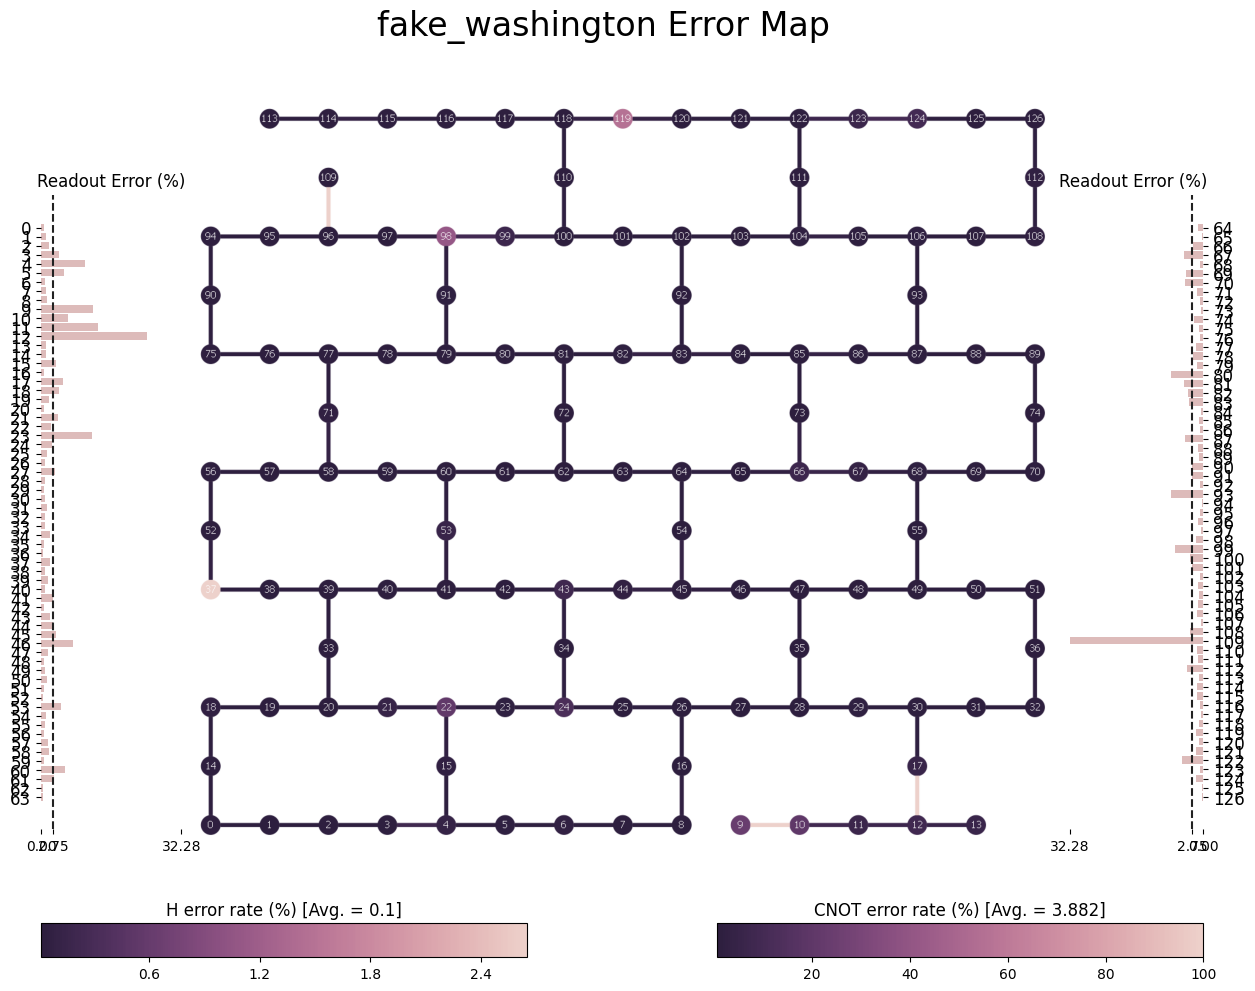

In [9]:
from qiskit.visualization import plot_error_map

plot_error_map(fake_backend)

## Map to backend using VF2 algorithm 

In [10]:
VF2_mapping_ranges, small_qc = get_VF2_layouts(circ, fake_backend)
print(len(VF2_mapping_ranges))
print(VF2_mapping_ranges)

mapping_range = VF2_mapping_ranges[0]
print(mapping_range)

23
[[3, 4, 6, 5], [15, 22, 20, 21], [2, 1, 14, 0], [23, 24, 26, 25], [33, 39, 37, 38], [34, 43, 41, 42], [27, 28, 30, 29], [44, 45, 47, 46], [53, 60, 58, 59], [54, 64, 62, 63], [17, 12, 10, 11], [48, 49, 51, 50], [65, 66, 68, 67], [71, 77, 75, 76], [72, 81, 79, 80], [73, 85, 83, 84], [86, 87, 89, 88], [91, 98, 96, 97], [92, 102, 100, 101], [93, 106, 104, 105], [107, 108, 126, 112], [110, 118, 116, 117], [111, 122, 120, 121]]
[3, 4, 6, 5]


In [11]:
pcs_VF2_mapping_ranges, pcs_small_qc = get_VF2_layouts(pcs_circ, fake_backend)
print(len(pcs_VF2_mapping_ranges))
print(pcs_VF2_mapping_ranges)

pcs_mapping_range = pcs_VF2_mapping_ranges[0]
print(pcs_mapping_range)

13
[[6, 5, 4, 3, 2, 15], [18, 19, 20, 21, 22, 33], [43, 34, 24, 25, 26, 23], [60, 53, 41, 40, 39, 42], [47, 35, 28, 29, 30, 27], [62, 63, 64, 54, 45, 65], [77, 71, 58, 57, 56, 59], [68, 55, 49, 50, 51, 48], [83, 82, 81, 80, 79, 72], [87, 86, 85, 73, 66, 84], [100, 99, 98, 97, 96, 91], [108, 107, 106, 105, 104, 93], [120, 119, 118, 117, 116, 110]]
[6, 5, 4, 3, 2, 15]


## Execute on noisy simulator

In [12]:
import qiskit_aer.noise as noise
from qiskit_aer.primitives import SamplerV2 as sampler

basis_gates = fake_backend.configuration().basis_gates
noise_model = noise.NoiseModel.from_backend(fake_backend)

noisy_sampler = sampler(options={"backend_options": {"noise_model": noise_model}})
ideal_sampler = sampler()

In [13]:
circ.measure_all()
pcs_circ.measure_all()

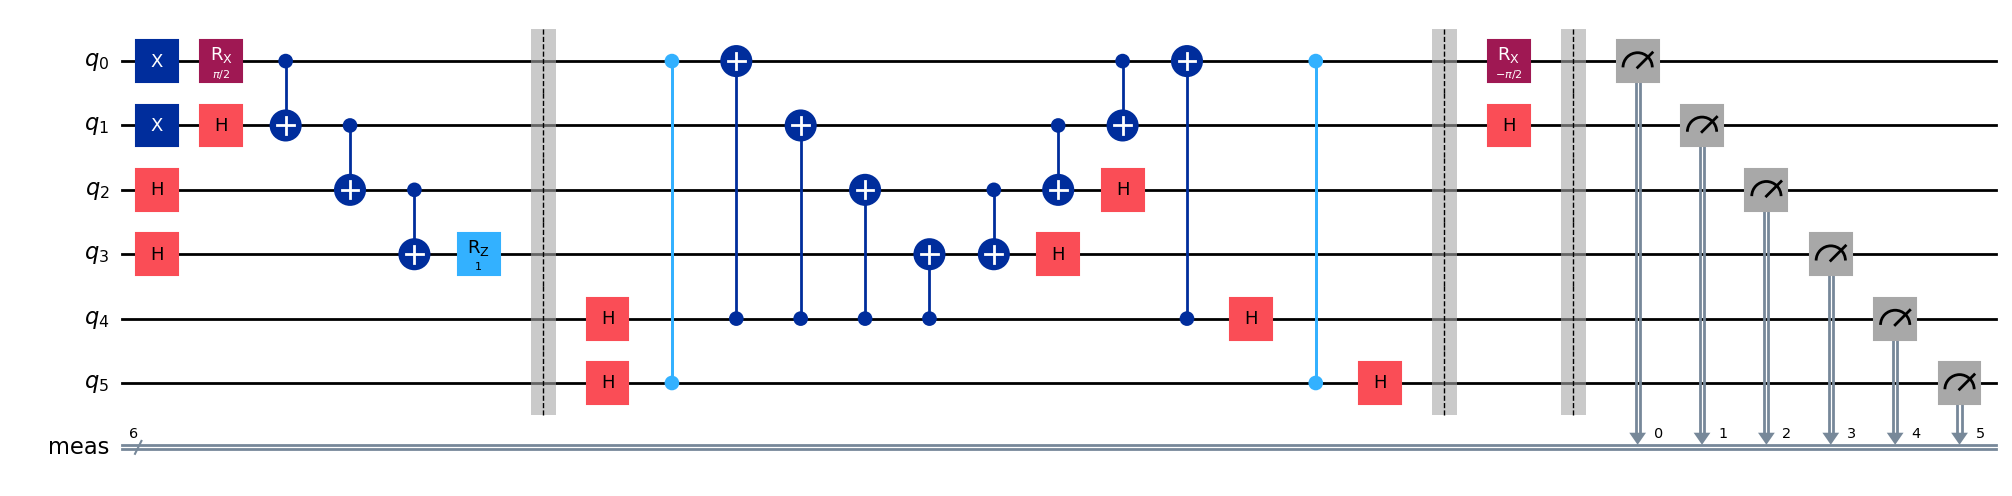

In [14]:
pcs_circ.draw("mpl", fold=-1)

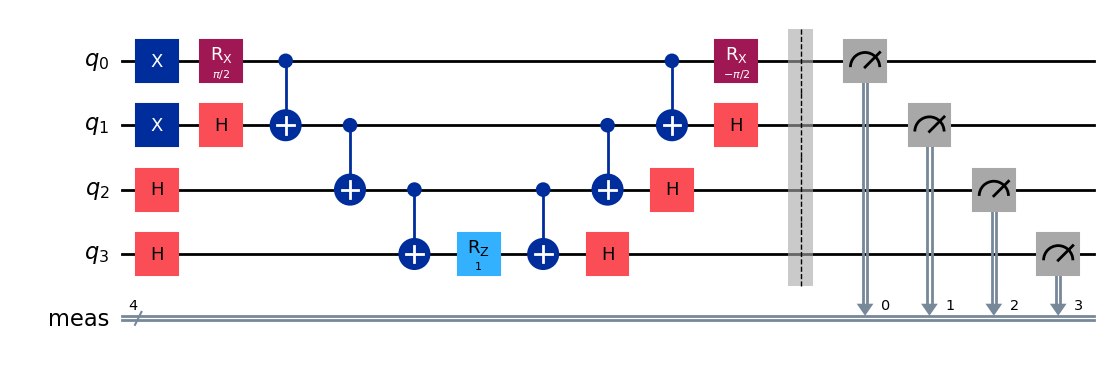

In [15]:
circ.draw("mpl", fold=-1)

In [16]:
from qiskit import transpile

pcs_circ_transpiled = transpile(
    pcs_circ,
    basis_gates=basis_gates,
    initial_layout=pcs_mapping_range,
    optimization_level=1,
)
circ_transpiled = transpile(
    circ, basis_gates=basis_gates, initial_layout=mapping_range, optimization_level=1
)

noisy_job_result = noisy_sampler.run(
    [pcs_circ_transpiled, circ_transpiled], shots=10000
).result()

pcs_circ_counts = noisy_job_result[0].data.meas.get_counts()
noisy_circ_counts = noisy_job_result[1].data.meas.get_counts()

ideal_job_result = ideal_sampler.run([circ], shots=10000).result()
ideal_circ_counts = ideal_job_result[0].data.meas.get_counts()
postselected_counts = postselect_counts(pcs_circ_counts, num_ancillas=2)

print(pcs_circ_counts)
print(postselected_counts)

{'001011': 524, '000001': 278, '000011': 4563, '001100': 1516, '010111': 23, '000000': 98, '110011': 16, '011011': 80, '000110': 36, '011100': 228, '100011': 179, '000111': 578, '010100': 189, '000100': 333, '001110': 86, '000010': 104, '001010': 28, '100000': 14, '001000': 181, '001111': 94, '010011': 223, '100001': 20, '101100': 59, '101011': 24, '001001': 29, '011111': 27, '000101': 51, '101101': 11, '001101': 21, '110010': 11, '010000': 66, '110001': 17, '010110': 16, '010001': 13, '010101': 7, '100111': 26, '100010': 31, '100110': 7, '110000': 3, '011101': 12, '011000': 35, '111110': 2, '100100': 14, '101001': 4, '010010': 28, '111000': 1, '111101': 5, '110100': 6, '011010': 6, '100101': 7, '011110': 14, '111100': 13, '011001': 7, '101000': 6, '101111': 5, '111011': 1, '110101': 7, '111010': 3, '101110': 4, '110111': 3, '111111': 2, '101010': 4, '110110': 1}
{'1011': 524, '0001': 278, '0011': 4563, '1100': 1516, '0000': 98, '0110': 36, '0111': 578, '0100': 333, '1110': 86, '0010':

In [17]:
from qiskit.quantum_info import hellinger_fidelity

raw_fidelity = hellinger_fidelity(ideal_circ_counts, noisy_circ_counts)
mitigated_fidelity = hellinger_fidelity(ideal_circ_counts, postselected_counts)
postselection_rate = sum(postselected_counts.values()) / sum(pcs_circ_counts.values())

print(f"raw fidelity: {raw_fidelity}")
print(f"mitigated fidelity: {mitigated_fidelity}")
print(f"postselection rate: {postselection_rate}")

raw fidelity: 0.6769743693209439
mitigated fidelity: 0.7127098897054072
postselection rate: 0.852
